# CAPSTONE 3. Predicting Major Cryptocurrencies Prices
## Modeling

In this notebook we will continue to implement different times series forecasting algorithms in order to predict Bitcoin price. In particular, we will build three models:
<ul>
    <i>Exponential Smoothing</i> - a time series forecasting method for univariate data, which can be used as an alternative for ARIMA family of methods<br>
    <i>Prophet</i> - a time-series forecasting model developped by Facebook<br>
    <i>PyCaret</i> - a Python version of the Caret machine learning package in R<br>
</ul>
As always, we will train the models on the training set and evaluate them on the test set. The train and test sets will be the same that we used in the previous notebook.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
import warnings
import os
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from joblib import Parallel
from joblib import delayed
from multiprocessing import cpu_count
from math import sqrt
import logging
logger = logging.getLogger('pycaret.regression')
logger.setLevel(logging.CRITICAL)

warnings.filterwarnings('ignore')

#setting figure's default size
sns.set(rc={'figure.figsize':(12,5)})
plt.rcParams['figure.figsize'] = (12,5)

sns.set_style('whitegrid')

pd.options.display.float_format = "{:.3f}".format

First, let's import the data we saved in the previous step. We will use it for our analysis.

In [2]:
df = pd.read_pickle('../PTDD/df.pkl')
train = np.load('../PTDD/train.npy')
test = np.load('../PTDD/test.npy')
btc = pd.read_pickle('../EDA/btc.pkl')
btc_val = np.load('../PTDD/btc_val.npy')
btc_price = btc['Price']

In [3]:
print(f'Train set observations: {len(train)}')
print(f'Test set observations: {len(test)}')

Train set observations: 2977
Test set observations: 30


And take a look once again at BTC price time series.

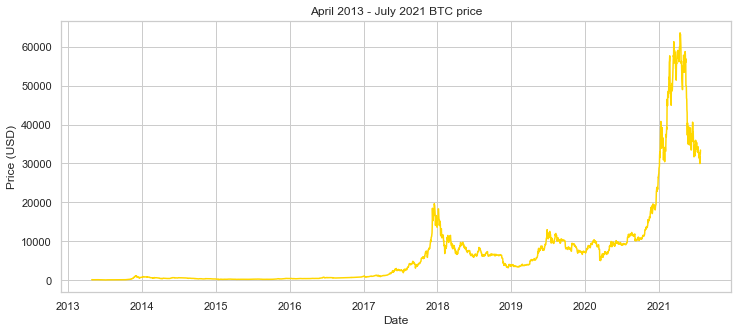

In [4]:
sns.lineplot(data=btc, x='Date', y='Price', color='Gold')
plt.title(f'April 2013 - July 2021 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

### Algorithm 1 - Exponential Smoothing

Exponential Smoothing (ES) is a time series forecasting algorithm which can be seen as an analog for Box-Jenkins ARIMA family of methonds. Both of them make a prediction as a weighted sum of previous observations. The main difference is that Exponential Smoothing uses an exponentially decreasing weight for previous observations, using parameter named "alpha". The bigger alpha is, the less important the older observations become for the prediction. If alpha is small, on the other hand, then the model pays more attention to the older obserbations.

There are three types of Exponential Smoothing:<br>
<ol>
    1. Single Exponential Smoothing - does not take into account trend and seasonalirt<br>
    2. Double Exponential Smoothing - takes trend into account<br>
    3. Triple Exponential Smoothing - takes into account both trend and seasonality<br>
</ol>

We know from the previous step that our time series is not stationary. We are not sure if it has clear seasonality, so we will build Double ES model first and than compare it to Triple ES, to see how seasonality will affect the model's performance.<br>
It is also important to understand what kind of trend our time series has - additive or multiplicative (we will need to specify it as a hyperparameter). On the graph we see that even though in the last couple month there is an exponential growth, for 5 years before that the general trend seems to be linear, so we will assume the additive trend as our baseline option.

In [5]:
# initializing a model, fitting on the train set and predicting for the next 30 observations (equivalent to the test set length)
btc_es_model_add = ExponentialSmoothing(train, trend='add')
btc_es_model_add_fit = btc_es_model_add.fit()
print(btc_es_model_add_fit.summary())
btc_es_model_add_pred = btc_es_model_add_fit.forecast(30)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2977
Model:             ExponentialSmoothing   SSE                              0.245
Optimized:                         True   AIC                         -27986.358
Trend:                         Additive   BIC                         -27962.363
Seasonal:                          None   AICC                        -27986.329
Seasonal Periods:                  None   Date:                 Mon, 26 Jul 2021
Box-Cox:                          False   Time:                         21:05:44
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9453416                alpha                 True
smoothing_trend             0.0000

In [6]:
predictions_test_add = [x for x in btc_es_model_add_pred] # List with predicted test values
observations_test_add = [x for x in test] # List with expected test values

In [7]:
r2 = r2_score(observations_test_add, predictions_test_add)
print(f'Test set r-squared for Double ES (additive) is: {round(r2, 2)}')
mape = mean_absolute_percentage_error(observations_test_add, predictions_test_add)
print(f'Test set MAPE for Double ES (additive) is: {round(mape, 2) * 100}%')

Test set r-squared for Double ES (additive) is: -0.23
Test set MAPE for Double ES (additive) is: 4.0%


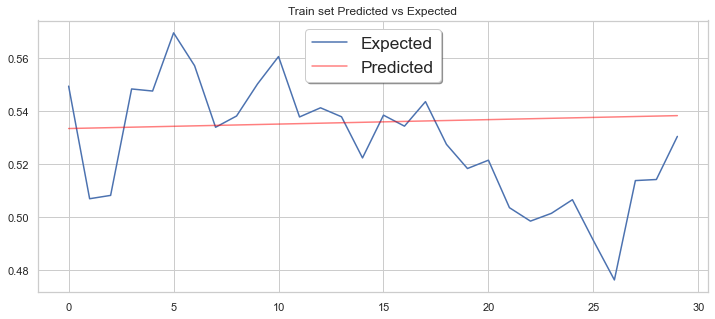

In [8]:
plt.plot(observations_test_add, label='Expected')
plt.plot(predictions_test_add, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Train set Predicted vs Expected")

plt.show()

As we can see, Exponential Smoothing with additive trend didn't work pretty much at all. We have a negative r-squared which means the model fits the data even worse than just a straight line. The Mean Absolute Percentage Error is also higher (4% against 3% of ARIMA(2,1,1)). Let's try to change the trend parameter to multiplicative.

In [9]:
btc_es_model_mul = ExponentialSmoothing(train, trend='mul')
btc_es_model_mul_fit = btc_es_model_mul.fit()
print(btc_es_model_mul_fit.summary())
btc_es_model_mul_pred = btc_es_model_mul_fit.forecast(30)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2977
Model:             ExponentialSmoothing   SSE                              0.250
Optimized:                         True   AIC                         -27928.177
Trend:                   Multiplicative   BIC                         -27904.183
Seasonal:                          None   AICC                        -27928.149
Seasonal Periods:                  None   Date:                 Mon, 26 Jul 2021
Box-Cox:                          False   Time:                         21:05:44
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9340681                alpha                 True
smoothing_trend            0.02319

In [10]:
predictions_test_mul = [x for x in btc_es_model_mul_pred]
observations_test_mul = [x for x in test]

In [11]:
r2 = r2_score(observations_test_mul, predictions_test_mul)
print(f'Test set r-squared for Double ES (multiplicative) is: {round(r2, 2)}')
mape = mean_absolute_percentage_error(observations_test_mul, predictions_test_mul)
print(f'Test set MAPE for Double ES (multiplicative) is: {round(mape, 2) * 100}%')

Test set r-squared for Double ES (multiplicative) is: -1.31
Test set MAPE for Double ES (multiplicative) is: 6.0%


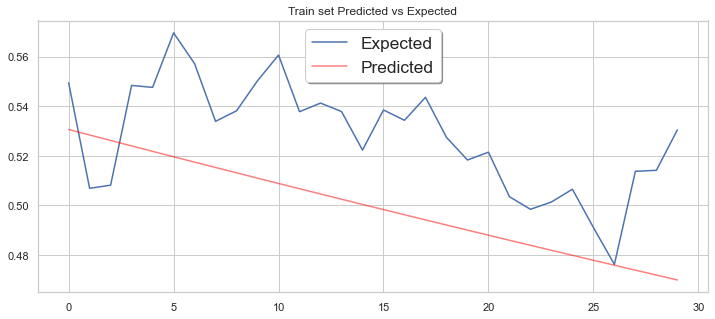

In [12]:
plt.plot(observations_test_mul, label='Expected')
plt.plot(predictions_test_mul, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Train set Predicted vs Expected")
plt.show()

As we see, changin the trend parameter to multiplicative didn't make the model performance any better. The results are actually even slightly worse than for the additive trend.

Now, let's perform a grid search for best parameters.

In [13]:
btc_es_model_mul = ExponentialSmoothing(train)
btc_es_model_mul_fit = btc_es_model_mul.fit(use_brute=True)
print(btc_es_model_mul_fit.summary())
btc_es_model_mul_pred = btc_es_model_mul_fit.forecast(30)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2977
Model:             ExponentialSmoothing   SSE                              0.246
Optimized:                         True   AIC                         -27989.112
Trend:                             None   BIC                         -27977.115
Seasonal:                          None   AICC                        -27989.099
Seasonal Periods:                  None   Date:                 Mon, 26 Jul 2021
Box-Cox:                          False   Time:                         21:05:44
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9472968                alpha                 True
initial_level              0.01106

In [14]:
predictions_test_mul = [x for x in btc_es_model_mul_pred]
observations_test_mul = [x for x in test]

In [15]:
r2 = r2_score(observations_test_mul, predictions_test_mul)
print(f'Test set r-squared for Double ES (gridsearch) is: {round(r2, 2)}')
mape = mean_absolute_percentage_error(observations_test_mul, predictions_test_mul)
print(f'Test set MAPE for Double ES (gridsearch) is: {round(mape, 2) * 100}%')

Test set r-squared for Double ES (gridsearch) is: -0.07
Test set MAPE for Double ES (gridsearch) is: 4.0%


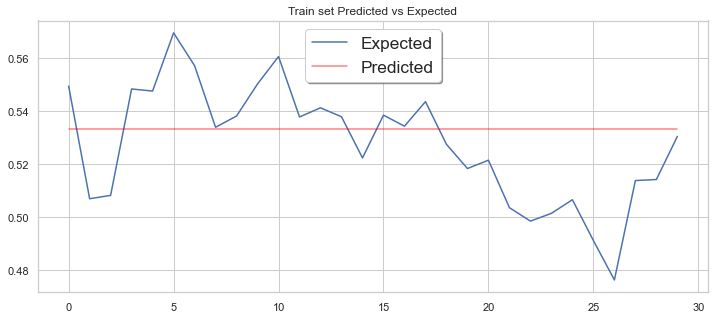

In [16]:
plt.plot(observations_test_mul, label='Expected')
plt.plot(predictions_test_mul, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Train set Predicted vs Expected")
plt.show()

As we can see, grid search didn't help us to improve the prediction. Exponential smoothing model was not able to catch the structure of the data and performed poorly.

### Algorithm 2 - Facebook Prophet

Next, we will start with Facebook Prophet model.<br>
Prophet is a time-series forecasting algorithm developped by Facebook and is a part of Kats - a framework for time-series analysis, which includes several models. It is important to note that, according to its developers, the main idea behind Prophet is to make *generic* time series analysis easier - generic meaning time series that are most common in business, which have any of the following characteristics:<br>
<ul>
    - hourly, daily, or weekly observations with at least a few months (preferably a year) of history<br>
    - strong multiple “human-scale” seasonalities: day of week and time of year<br>
    - important holidays that occur at irregular intervals that are known in advance<br>
    - a reasonable number of missing observations or large outliers<br>
    - historical trend changes, for instance due to product launches or logging changes<br>
    - trends that are non-linear growth curves, where a trend hits a natural limit or saturates<br>
</ul>
    
Prophet "<i>implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects</i> [Package "prophet", 2019].<br>

The Prophet's fit() function takes a DataFrame of time series data. The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the datetime objects. The second column must have the name ‘y‘ and contain the observations.

In [17]:
# subsetting the "date" and "close" columns from the original dataframe
btc_prophet_df = btc[['Date', 'Price']]
# renaming the columns according to Prophet's standard
btc_prophet_df.columns = ['ds', 'y']
# making sure 'ds' column observations are datetime objects
btc_prophet_df['ds'] = pd.to_datetime(btc_prophet_df['ds'])

In [18]:
# train-test split
train_size = int(len(btc_prophet_df) * 0.9901)
train_pr, test_pr = btc_prophet_df[0:train_size], btc_prophet_df[train_size:len(btc_prophet_df)]
print(f'Total Observations: {(len(btc_prophet_df))}')
print(f'Training Observations: {(len(train_pr))}')
print(f'Testing Observations: {(len(test_pr))}')

Total Observations: 3007
Training Observations: 2977
Testing Observations: 30


In [19]:
btc_prophet_mod = Prophet()
btc_prophet_mod.fit(train_pr);
btc_prophet_pred = btc_prophet_mod.predict(test_pr)
print(btc_prophet_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-06-25 41615.343   35822.714   47642.143
1 2021-06-26 41715.832   35609.227   48060.610
2 2021-06-27 41796.397   35873.580   48033.302
3 2021-06-28 41846.459   35727.979   48362.137
4 2021-06-29 41945.225   35788.092   47739.729


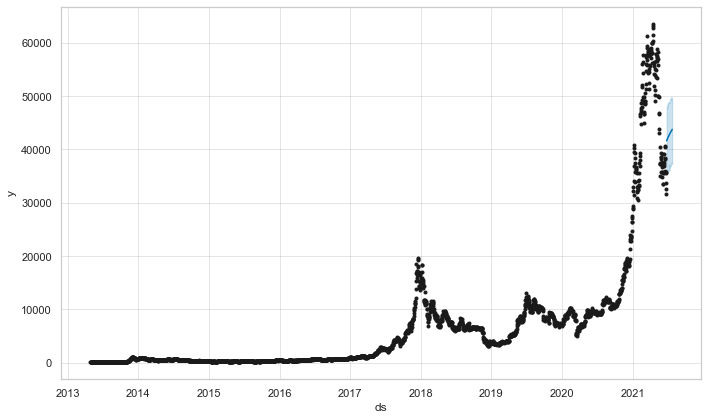

In [20]:
btc_prophet_mod.plot(btc_prophet_pred);

In [21]:
r2 = r2_score(test_pr['y'], btc_prophet_pred['yhat'])
print(f'Test set r-squared for Prophet is: {round(r2, 2)}')
mape = mean_absolute_percentage_error(test_pr['y'], btc_prophet_pred['yhat'])
print(f'Test set MAPE for Prophet is: {round(mape,1) * 100}%')

Test set r-squared for Prophet is: -45.99
Test set MAPE for Prophet is: 30.0%


In [22]:
test_pr = test_pr.reset_index().drop('index', axis=1)

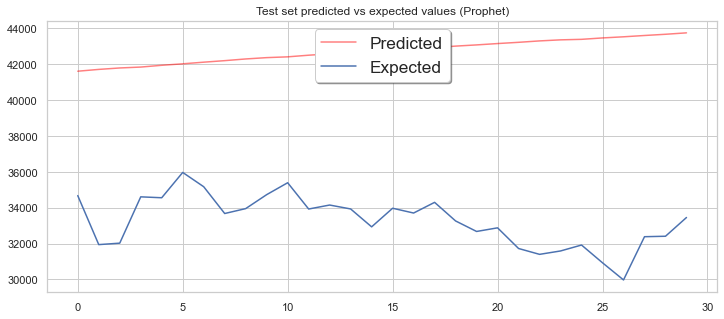

In [23]:
plt.plot(btc_prophet_pred['yhat'], label='Predicted', color='red', alpha=0.5)
plt.plot(test_pr['y'], label='Expected')
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('Test set predicted vs expected values (Prophet)')
plt.show()

Again, the results are bad. This is, however, a little bit more understandable. As I mentioned above, Prophet is not really created to handle time-series like BTC price - which is quite volatile, doesn't have clear seasonality and overall hard to predict.

Now let's see if the grid search will help us to improve the model's performance

In [24]:
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [3,5,10,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 200


In [25]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    btc_prophet_mod_grid = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         interval_width=0.95)
    btc_prophet_mod_grid.fit(train_pr)
    btc_prophet_pred_grid = btc_prophet_mod_grid.predict(test_pr)
     
    model_parameters = model_parameters.append({'MAPE':mape,'Parameters':p}, ignore_index=True)

In [40]:
prophet_parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 3,
 'seasonality_mode': 'multiplicative'}

We can see that this parameters for Prophet shows the best MAPE. Now let's fit the model with those parameters.

In [34]:
btc_prophet_mod = Prophet(changepoint_prior_scale=0.1, holidays_prior_scale=0.1, n_changepoints=3, seasonality_mode='multiplicative')
btc_prophet_mod.fit(train_pr);
btc_prophet_pred = btc_prophet_mod.predict(test_pr)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


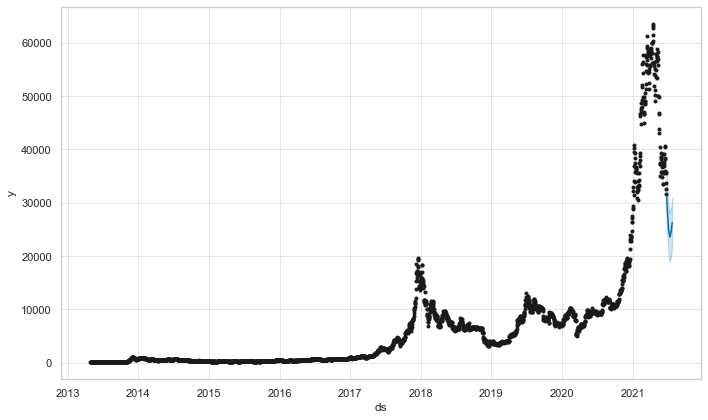

In [35]:
btc_prophet_mod.plot(btc_prophet_pred);

In [38]:
r2 = r2_score(test_pr['y'], btc_prophet_pred['yhat'])
print(f'Test set r-squared for Prophet is: {round(r2, 2)}')
mape = mean_absolute_percentage_error(test_pr['y'], btc_prophet_pred['yhat'])
print(f'Test set MAPE for Prophet is: {round(mape,2) * 100}%')

Test set r-squared for Prophet is: -29.5
Test set MAPE for Prophet is: 22.0%


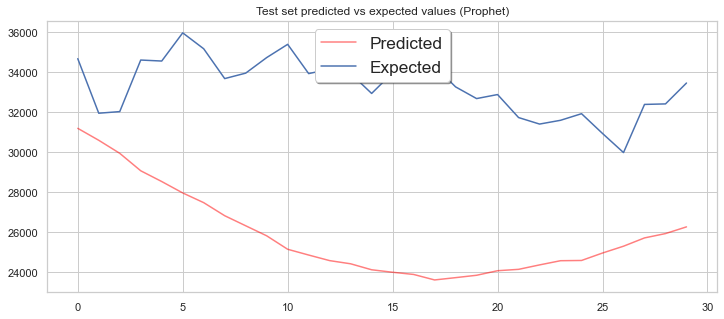

In [37]:
plt.plot(btc_prophet_pred['yhat'], label='Predicted', color='red', alpha=0.5)
plt.plot(test_pr['y'], label='Expected')
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('Test set predicted vs expected values (Prophet)')
plt.show()

Even the results are a bit better, they are still much worse than those of the baseline ARIMA(2,1,1). In the next notebook we will build PyCaret model and see how it performs.

Here is a quick summary table of all the models we've built. All the models performance were checked using the same exact test set.

| MODEL | OBSERVATIONS | r-squared | MAPE |
| ------| -------------|---- | ---- | 
| ARIMA(2,1,1)| 30 | 0.37 | 3% |
| Exponential Smoothing (additive) | 30 | -0.23 | 4% |
| Exponential Smoothing (multiplicative)| 30 | -1.31 | 6% |
| Exponential Smoothing (grid search)| 30 | -0.07 | 4% |
| Facebook Prophet (no grid search) | 30 | -45.99 | 30% |
| Facebook Prophet (grid search)    | 30 | -29.5  | 22% |